In [1]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer

import oracles
from optimization import GDClassifier, SGDClassifier
from utils import grad_finite_diff

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

#отображение графиков в ноутбуке
%matplotlib inline

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg'

import json
import time
import random
from datetime import datetime

In [2]:
data_train = pd.read_csv('toxic_train.csv')
data_test = pd.read_csv('toxic_test.csv')
data_train

Unnamed: 0                                       comment_text  is_toxic
0               0  Explanation\nWhy the edits made under my usern...     False
1               1  D'aww! He matches this background colour I'm s...     False
2               2  Hey man, I'm really not trying to edit war. It...     False
3               3  "\nMore\nI can't make any real suggestions on ...     False
4               4  You, sir, are my hero. Any chance you remember...     False
...           ...                                                ...       ...
52056      159494  "\n\n our previous conversation \n\nyou fuckin...      True
52057      159514                  YOU ARE A MISCHIEVIOUS PUBIC HAIR      True
52058      159541  Your absurd edits \n\nYour absurd edits on gre...      True
52059      159546  "\n\nHey listen don't you ever!!!! Delete my e...      True
52060      159554  and i'm going to keep posting the stuff u dele...      True

[52061 rows x 3 columns]

In [745]:
y_train = (data_train['is_toxic'] * 2 - 1).to_numpy()
y_test = (data_test['is_toxic'] * 2 - 1).to_numpy()

array([-1, -1, -1, ...,  1,  1,  1])

## Эксперимент 1

In [4]:
def str_editor(input_string: str):
    result = ''
    for i, c in enumerate(input_string):
        if c.isalnum():
             result += c
        else:
            result += ' '
    result = result.lower()
    return result
    

In [5]:
data_train['comment_text'] = data_train['comment_text'].apply(str_editor)
data_test['comment_text'] = data_test['comment_text'].apply(str_editor)

## Эксперимент 2-3

In [ ]:
dfs = np.logspace(-5, -1, 10)
accs = np.zeros(10)
for i, df in enumerate(dfs):
    vectorizer = CountVectorizer(min_df=df)
    
    X_train = vectorizer.fit_transform(data_train['comment_text'])
    X_test = vectorizer.transform(data_test['comment_text'])

    cls1 = GDClassifier(loss_function='binary_logistic', step_alpha=0.01, step_beta=0.75,
        tolerance=1e-5, max_iter=1000, l2_coef=1.0)
    history1 = cls1.fit(X_train, y_train, w_0=None, trace=True)
    y_pred1 = cls1.predict(X_test)
    y_probs1 = cls1.predict_proba(X_test)[:, 1]
    print(df)
    print('Accuracy GD:', (y_pred1 == y_test).sum() / len(y_test))
    print('ROC-AUC GD:', roc_auc_score(y_test, y_probs1))
    accs[i] = (y_pred1 == y_test).sum() / len(y_test)

## Эксперимент 4

In [6]:
vectorizer = CountVectorizer(min_df=0.025)

X_train = vectorizer.fit_transform(data_train['comment_text'])
X_test = vectorizer.transform(data_test['comment_text'])
print(X_train.shape)


(52061, 232)


### 1

In [148]:
d_exp4 = dict()

# alphas = np.logspace(-5, 1, )
# betas =  [0, 1e-5, 0.25, 0.5, 0.75, 1]
# #l2_coefs = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# l2_coefs = [1e-4]

#l2_coefs = np.logspace(-5, 0, 6)
l2_coefs = [0.01]
alphas = np.logspace(-3, 0, 4)
betas = np.linspace(0, 1, 5)

max_iter = 1000

for l2_coef in l2_coefs:
    start_time = time.time()
    for alpha in alphas:
        for beta in betas:
            cls = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta,
                tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)

            history = cls.fit(X_train, y_train, w_0=None, trace=True)
            y_pred = cls.predict(X_test)
            y_probs = cls.predict_proba(X_test)[:, 1]

            accuracy = (y_test == y_pred).sum() / len(y_test)
            roc_auc = roc_auc_score(y_test, y_probs)

            d_exp4[(l2_coef, alpha, beta)] = history, accuracy, roc_auc

            #print(f"l2_coef={l2_coef}, alpha={alpha}, beta={beta}",
            #      f"Accuracy: {accuracy}",
            #      f"ROC_AUC:, {roc_auc}", sep='\n', end='\n\n')
    print(f'done for l2_coef={l2_coef} in {time.time() - start_time:.3f} seconds')

done for l2_coef=0.01 in 358.478 seconds


In [149]:
d_exp4_to_json = dict()
for (l2_coef, alpha, beta), val in d_exp4.items():
    d_exp4_to_json[f"l2_coef={l2_coef}, alpha={alpha}, beta={beta}"] = val

print('max accuracy:', *max([(key, val[1]) for key, val in d_exp4_to_json.items()], key=lambda x: x[1]))
print('max roc-auc:', *max([(key, val[2]) for key, val in d_exp4_to_json.items()], key=lambda x: x[1]))
print('min_func value:', *min([(key, val[0]['func'][-1]) for key, val in d_exp4_to_json.items()], key=lambda x: x[1]))

with open(f'dump/d_exp4_max_iter_{max_iter}_{datetime.now().strftime("m%m-d%d-%H-%M-%S")}.json', 'w') as json_file:
    json.dump(d_exp4_to_json, json_file, indent=4, sort_keys=True)

max accuracy: l2_coef=0.01, alpha=1.0, beta=0.25 0.7961888179531824
max roc-auc: l2_coef=0.01, alpha=1.0, beta=0.25 0.8688491673273665
min_func value: l2_coef=0.01, alpha=1.0, beta=0.25 0.4678256274200824


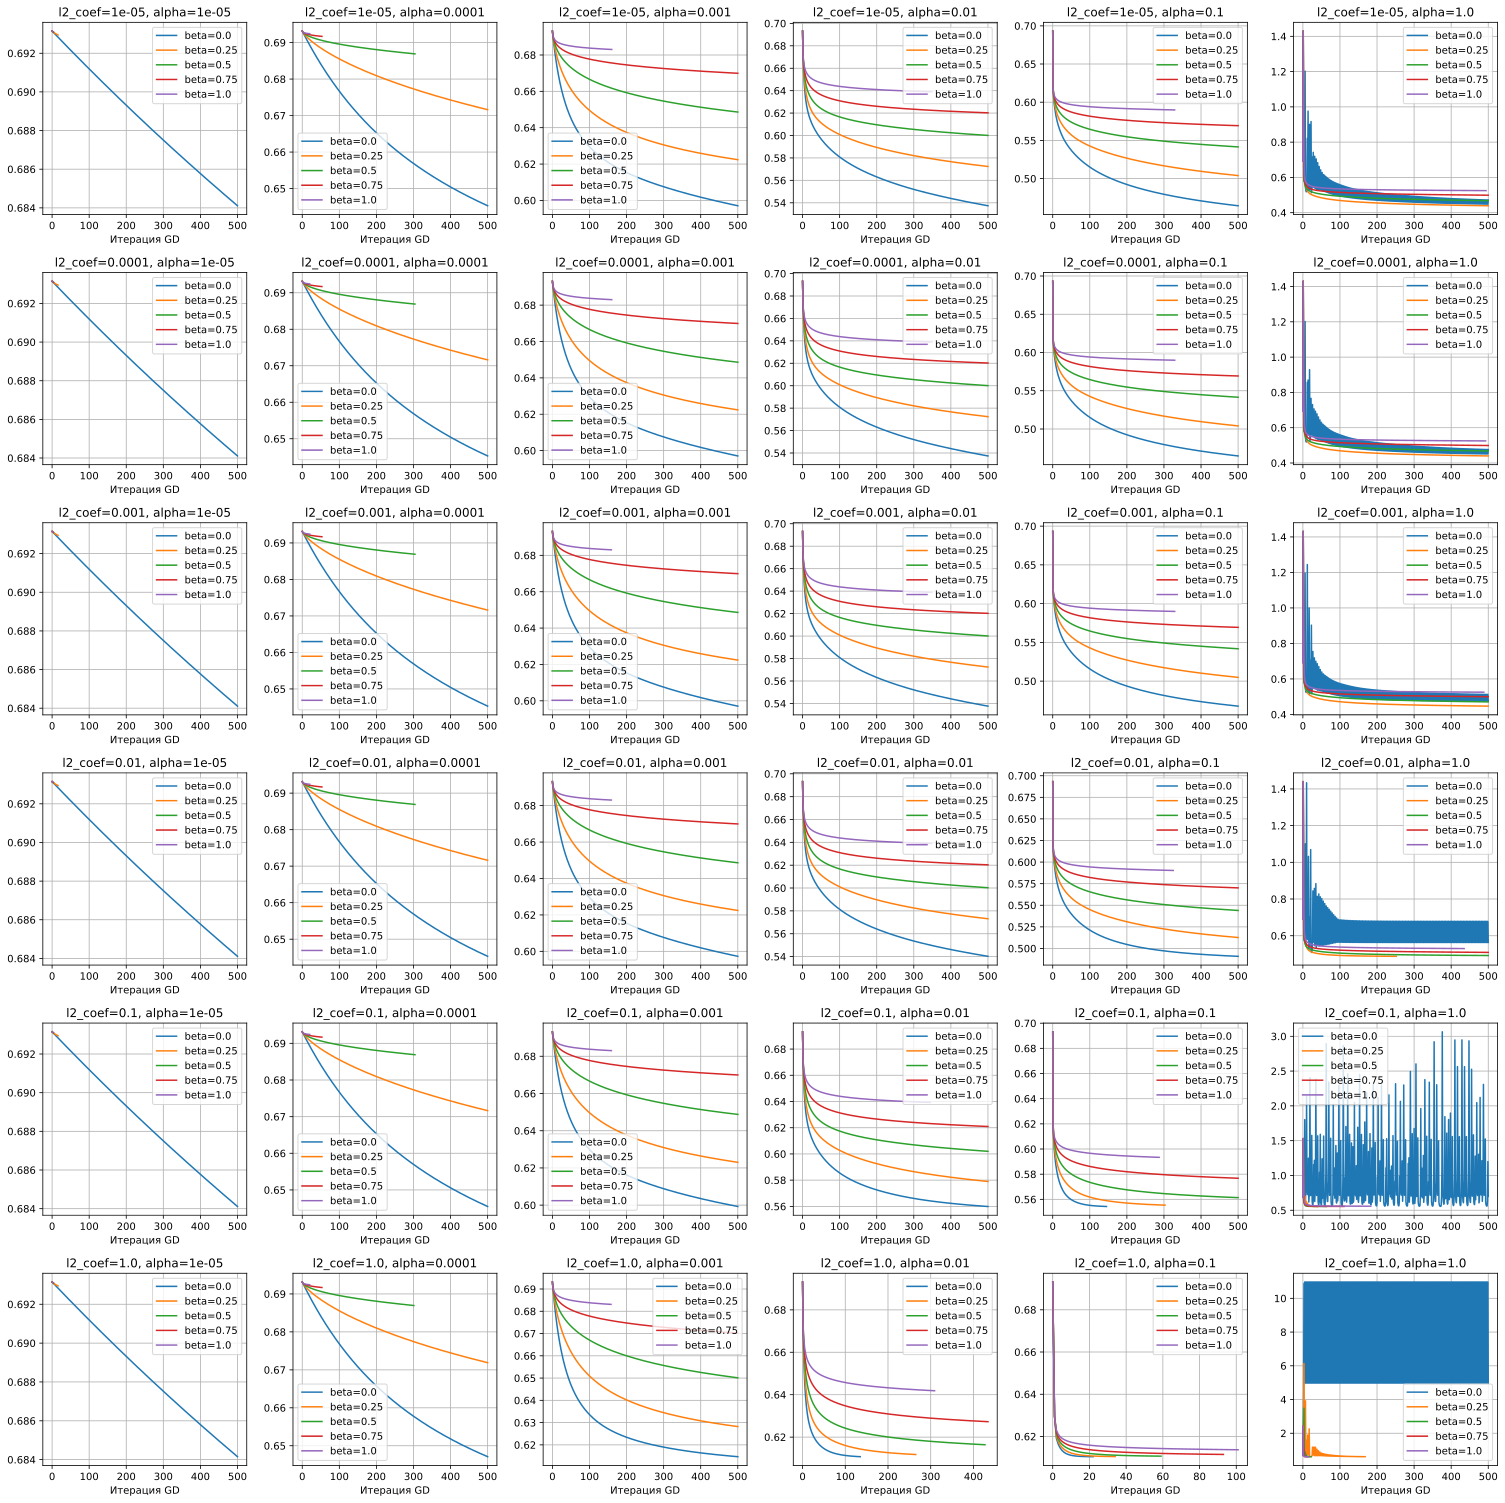

In [129]:
fig, ax = plt.subplots(len(l2_coefs), len(alphas))

#ax[0].set_ylabel('Функция ошибки')
for j, l2_coef in enumerate(l2_coefs):
    for i, alpha in enumerate(alphas):
        for beta in betas:
            ax[j, i].plot(d_exp4[(l2_coef, alpha, beta)][0]['func'], label=f'beta={beta}')
            ax[j, i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_xlabel('Итерация GD')

fig.set_size_inches(3.5 * len(alphas), 3.5 * len(l2_coefs) )
fig.tight_layout()
# plt.savefig('alpha_beta_1.svg')
plt.show()


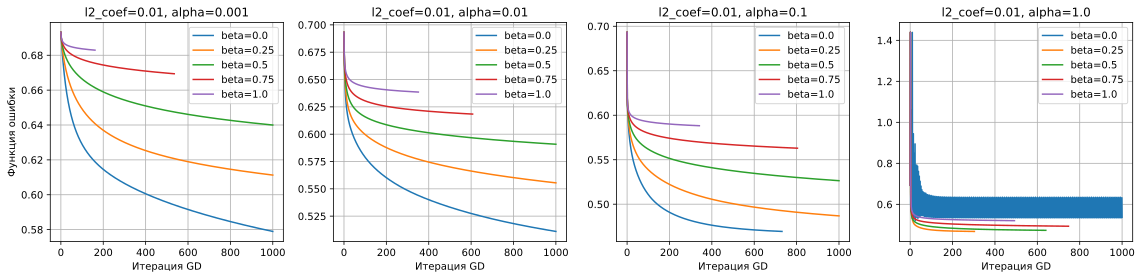

In [153]:
fig, ax = plt.subplots(1, len(alphas))
l2_coef = l2_coefs[0]
ax[0].set_ylabel('Функция ошибки')

for i, alpha in enumerate(alphas):
    for beta in betas:
        ax[i].plot(d_exp4[(l2_coef, alpha, beta)][0]['func'], label=f'beta={beta}')
        ax[i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
        ax[i].grid()
        ax[i].legend()
        ax[i].set_xlabel('Итерация GD')

fig.set_size_inches(4 * len(alphas), 4 )
fig.tight_layout()
plt.savefig('alpha_beta_new.svg')
plt.show()


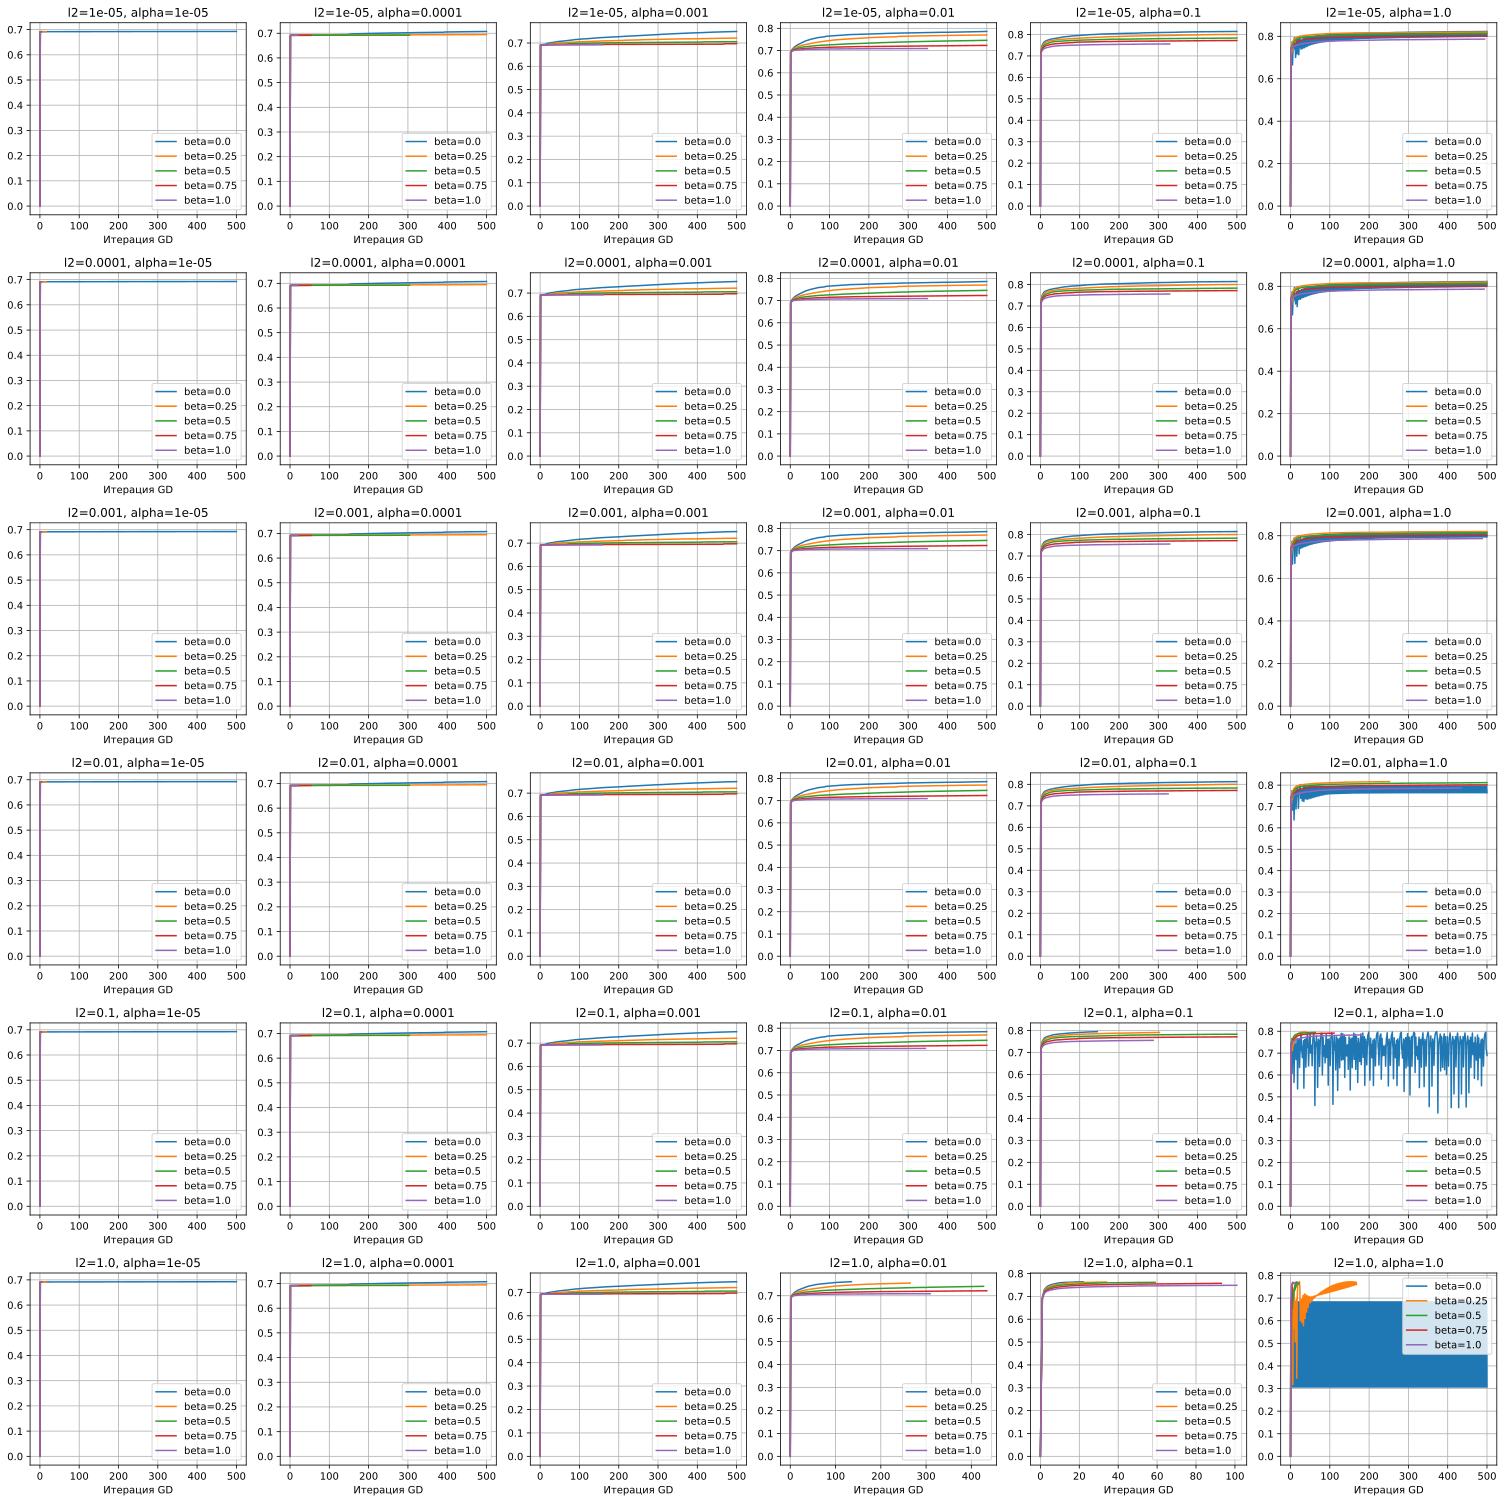

In [130]:
fig, ax = plt.subplots(len(l2_coefs), len(alphas))

#ax[0].set_ylabel('Accuracy')
for j, l2_coef in enumerate(l2_coefs):
    for i, alpha in enumerate(alphas):
        for beta in betas:
            ax[j, i].plot(d_exp4[(l2_coef, alpha, beta)][0]['accuracy'], label=f'beta={beta}')
            ax[j, i].set_title(f"l2={l2_coef}, alpha={alpha}")
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_xlabel('Итерация GD')

fig.set_size_inches(3.5 * len(alphas), 3.5 * len(l2_coefs))
fig.tight_layout()

#plt.savefig('alpha_beta_2.svg')

plt.show()

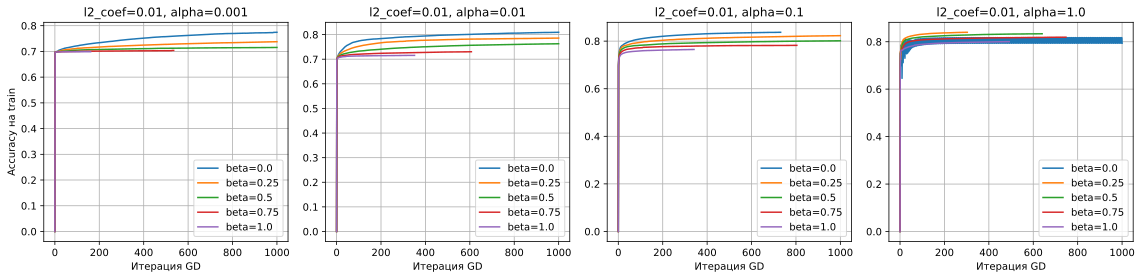

In [152]:
fig, ax = plt.subplots(1, len(alphas))
l2_coef = l2_coefs[0]
ax[0].set_ylabel('Accuracy на train')

for i, alpha in enumerate(alphas):
    for beta in betas:
        ax[i].plot(d_exp4[(l2_coef, alpha, beta)][0]['accuracy'], label=f'beta={beta}')
        ax[i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
        ax[i].grid()
        ax[i].legend()
        ax[i].set_xlabel('Итерация GD')

fig.set_size_inches(4 * len(alphas), 4 )
fig.tight_layout()
plt.savefig('alpha_beta_acc.svg')
plt.show()


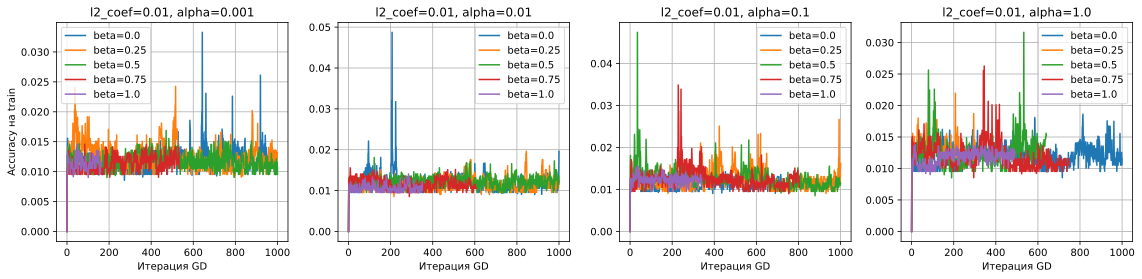

In [154]:
fig, ax = plt.subplots(1, len(alphas))
l2_coef = l2_coefs[0]
ax[0].set_ylabel('Accuracy на train')

for i, alpha in enumerate(alphas):
    for beta in betas:
        ax[i].plot(d_exp4[(l2_coef, alpha, beta)][0]['time'], label=f'beta={beta}')
        ax[i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
        ax[i].grid()
        ax[i].legend()
        ax[i].set_xlabel('Итерация GD')

fig.set_size_inches(4 * len(alphas), 4 )
fig.tight_layout()
plt.savefig('alpha_beta_acc.svg')
plt.show()


### Вспомогательное

In [15]:
cls = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.5,
            tolerance=1e-5, max_iter=500, l2_coef=0.5)
np.random.seed(42)

history = cls.fit(X_train, y_train, w_0=np.random.randn(X_train.shape[1]) * 1e-5 , trace=True)
y_pred = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)[:, 1]

print('ROC_AUC:', roc_auc_score(y_test, y_probs))
print('Accuracy:', (y_test == y_pred).sum() / len(y_test))

ROC_AUC: 0.7739637534203208
Accuracy: 0.7459856838846972


In [191]:
def f(w0, alpha=1.0, beta=0.25, l2_coef=0.01):
    cls = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta,
        tolerance=1e-5, max_iter=1000, l2_coef=l2_coef)
    history = cls.fit(X_train, y_train, w_0=w0, trace=True)
    y_pred = cls.predict(X_test)
    y_probs = cls.predict_proba(X_test)[:, 1]
    return history, y_pred, y_probs

np.random.seed(42)
d_w0 = dict()

sigma_list = [1e-2, 0.1, 0.5, 1, 5]
a_list = [1e-2, 0.1, 0.5, 1, 5]

for way in ['N', 'U', 'Z']:
    if way == 'N':
        for sigm in sigma_list:
            w0 = np.random.randn(X_train.shape[1]) * sigm
            history, y_pred, y_probs = f(w0) 
            d_w0[(way, sigm)] = history, y_pred, y_probs
            print(way, sigm)
            print('ROC_AUC:', roc_auc_score(y_test, y_probs))
            print('Accuracy:', (y_test == y_pred).sum() / len(y_test))
    elif way == 'U':
        for a in a_list:
            w0 = np.random.uniform(-a, a, X_train.shape[1])
            history, y_pred, y_probs = f(w0) 
            d_w0[(way, a)] = history, y_pred, y_probs
            print(way, a)
            print('ROC_AUC:', roc_auc_score(y_test, y_probs))
            print('Accuracy:', (y_test == y_pred).sum() / len(y_test))
    else:
        w0 = None
        history, y_pred, y_probs = f(w0) 
        d_w0[way] = history, y_pred, y_probs
        print(way)
        print('ROC_AUC:', roc_auc_score(y_test, y_probs))
        print('Accuracy:', (y_test == y_pred).sum() / len(y_test))

N 0.01
ROC_AUC: 0.8367698379380222
Accuracy: 0.7644612110659702
N 0.1
ROC_AUC: 0.8372163381568387
Accuracy: 0.7648964983555814
N 0.5
ROC_AUC: 0.8382929961027007
Accuracy: 0.764606306829174
N 1
ROC_AUC: 0.8395844251818532
Accuracy: 0.7656219771716
N 5
ROC_AUC: 0.8196411575227402
Accuracy: 0.743905977945444
U 0.01
ROC_AUC: 0.8367723128224127
Accuracy: 0.7645095763203714
U 0.1
ROC_AUC: 0.837024029651379
Accuracy: 0.7647997678467788
U 0.5
ROC_AUC: 0.8380235943935721
Accuracy: 0.7652834203907912
U 1
ROC_AUC: 0.838625529560058
Accuracy: 0.7647997678467788
U 5
ROC_AUC: 0.8346284802881395
Accuracy: 0.7592861288450378
Z
ROC_AUC: 0.8367754757912526
Accuracy: 0.7646546720835752


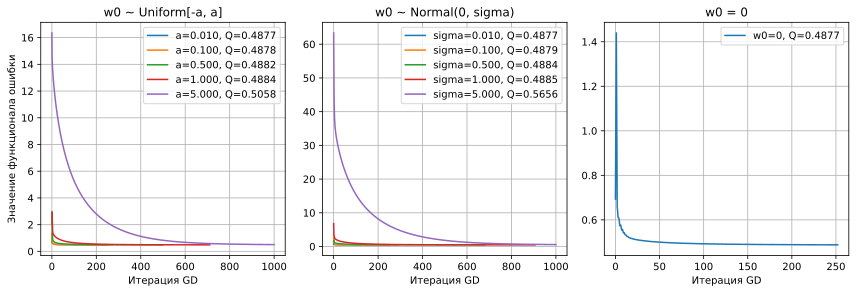

In [198]:
fig, ax = plt.subplot_mosaic('UNZ')

ax['U'].set_ylabel('Значение функционала ошибки')
ax['Z'].plot(d_w0['Z'][0]['func'], label=f'w0=0, Q={d_w0['Z'][0]['func'][-1]:.4f}')

for a in a_list:
    ax['U'].plot(d_w0[('U', a)][0]['func'], label=f'a={a:.3f}, Q={d_w0[('U', a)][0]['func'][-1]:.4f}')

for sigm in sigma_list:
    ax['N'].plot(d_w0['N', sigm][0]['func'], label=f'sigma={sigm:.3f}, Q={d_w0[('N', sigm)][0]['func'][-1]:.4f}')

ax['Z'].legend()
ax['N'].legend()
ax['U'].legend()

ax['U'].grid()
ax['N'].grid()
ax['Z'].grid()

ax['U'].set_title(f"w0 ~ Uniform[-a, a]")
ax['N'].set_title(f"w0 ~ Normal(0, sigma)")
ax['Z'].set_title(f"w0 = 0")

fig.set_size_inches(12, 4)
fig.tight_layout()

ax['U'].set_xlabel('Итерация GD')
ax['N'].set_xlabel('Итерация GD')
ax['Z'].set_xlabel('Итерация GD')

plt.savefig('w0_grad_func.svg')
plt.show()

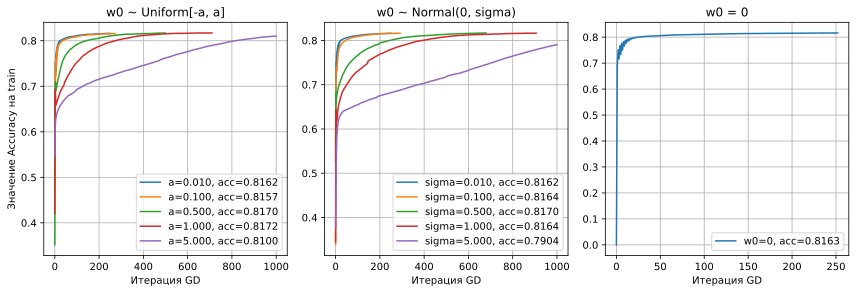

In [199]:
fig, ax = plt.subplot_mosaic('UNZ')

ax['U'].set_ylabel('Значение Accuracy на train')
ax['Z'].plot(d_w0['Z'][0]['accuracy'], label=f'w0=0, acc={d_w0['Z'][0]['accuracy'][-1]:.4f}')

for a in a_list:
    ax['U'].plot(d_w0[('U', a)][0]['accuracy'], label=f'a={a:.3f}, acc={d_w0[('U', a)][0]['accuracy'][-1]:.4f}')

for sigm in sigma_list:
    ax['N'].plot(d_w0['N', sigm][0]['accuracy'], label=f'sigma={sigm:.3f}, acc={d_w0[('N', sigm)][0]['accuracy'][-1]:.4f}')

ax['Z'].legend()
ax['N'].legend()
ax['U'].legend()

ax['U'].grid()
ax['N'].grid()
ax['Z'].grid()

ax['U'].set_title(f"w0 ~ Uniform[-a, a]")
ax['N'].set_title(f"w0 ~ Normal(0, sigma)")
ax['Z'].set_title(f"w0 = 0")

fig.set_size_inches(12, 4)
fig.tight_layout()

ax['U'].set_xlabel('Итерация GD')
ax['N'].set_xlabel('Итерация GD')
ax['Z'].set_xlabel('Итерация GD')

plt.savefig('w0_grad_acc.svg')
plt.show()

### Веса

In [161]:
def f(w0, alpha=0.1, beta=0.5):
    cls = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta,
        tolerance=1e-5, max_iter=1000, l2_coef=0.01)
    history = cls.fit(X_train, y_train, w_0=w0, trace=True)
    y_pred = cls.predict(X_test)
    y_probs = cls.predict_proba(X_test)[:, 1]
    return history, y_pred, y_probs

np.random.seed(42)
d_exp4_w0 = dict()

sigma_list = np.logspace(-3, -1, 3)
a_list = np.logspace(-3, -1, 3)

for way in ['N', 'U', 'Z']:
    if way == 'N':
        for sigm in sigma_list:
            w0 = np.random.randn(X_train.shape[1]) * sigm
            history, y_pred, y_probs = f(w0) 
            d_exp4_w0[(way, sigm)] = history, y_pred, y_probs
            print(way, sigm)
            print('ROC_AUC:', roc_auc_score(y_test, y_probs))
            print('Accuracy:', (y_test == y_pred).sum() / len(y_test))
    elif way == 'U':
        for a in a_list:
            w0 = np.random.uniform(-a, a, X_train.shape[1])
            history, y_pred, y_probs = f(w0) 
            d_exp4_w0[(way, a)] = history, y_pred, y_probs
            print(way, a)
            print('ROC_AUC:', roc_auc_score(y_test, y_probs))
            print('Accuracy:', (y_test == y_pred).sum() / len(y_test))
    else:
        w0 = None
        history, y_pred, y_probs = f(w0)
        d_exp4_w0[way] = history, y_pred, y_probs
        print(way)
        print('ROC_AUC:', roc_auc_score(y_test, y_probs))
        print('Accuracy:', (y_test == y_pred).sum() / len(y_test))

N 0.001
ROC_AUC: 0.7944463183647554
Accuracy: 0.7420197330237958
N 0.01
ROC_AUC: 0.7947400416395416
Accuracy: 0.7417295414973882
N 0.1
ROC_AUC: 0.775746408207498
Accuracy: 0.7208357515960534
U 0.001
ROC_AUC: 0.7943186786993992
Accuracy: 0.741487715225382
U 0.01
ROC_AUC: 0.7944415350680186
Accuracy: 0.741487715225382
U 0.1
ROC_AUC: 0.7904550512218388
Accuracy: 0.7356838846972336
Z
ROC_AUC: 0.7943761337509206
Accuracy: 0.7415360804797834


In [ ]:

plt.plot(d_exp4_w0[('U', 0.001)][0]['func'] )

## Эксперимент 5

In [24]:
d_exp5 = dict()

# alphas = np.logspace(-5, 1, )
# betas =  [0, 1e-5, 0.25, 0.5, 0.75, 1]
# #l2_coefs = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# l2_coefs = [1e-4]

l2_coefs = np.logspace(-6, 0, 4)
alphas = np.logspace(-3, 0, 4)
betas = np.linspace(0, 1, 5)

max_iter = 100

for l2_coef in l2_coefs:
    start_time = time.time()
    for alpha in alphas:
        for beta in betas:
            cls = SGDClassifier(loss_function='binary_logistic', batch_size=1_000, step_alpha=alpha, step_beta=beta,
                tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)

            history = cls.fit(X_train, y_train, w_0=None, trace=True, log_freq=5)
            y_pred = cls.predict(X_test)
            y_probs = cls.predict_proba(X_test)[:, 1]

            accuracy = (y_test == y_pred).sum() / len(y_test)
            roc_auc = roc_auc_score(y_test, y_probs)

            d_exp5[(l2_coef, alpha, beta)] = history, accuracy, roc_auc

            print(f"l2_coef={l2_coef}, alpha={alpha}, beta={beta}",
                   f"Accuracy: {accuracy}",
                   f"ROC_AUC: {roc_auc}", sep='\t')
    print(f'done for l2_coef={l2_coef} in {time.time() - start_time:.3f} seconds')

l2_coef=1e-06, alpha=0.001, beta=0.0	Accuracy: 0.7399400270845424	ROC_AUC: 0.7908848709418264
l2_coef=1e-06, alpha=0.001, beta=0.25	Accuracy: 0.7316695685819308	ROC_AUC: 0.7727754371253457
l2_coef=1e-06, alpha=0.001, beta=0.5	Accuracy: 0.7263977558521958	ROC_AUC: 0.7577853398258763
l2_coef=1e-06, alpha=0.001, beta=0.75	Accuracy: 0.7200619075256336	ROC_AUC: 0.7448777967012099
l2_coef=1e-06, alpha=0.001, beta=1.0	Accuracy: 0.7172083575159606	ROC_AUC: 0.7396002444653067
l2_coef=1e-06, alpha=0.01, beta=0.0	Accuracy: 0.7636873669955504	ROC_AUC: 0.8362758154996549
l2_coef=1e-06, alpha=0.01, beta=0.25	Accuracy: 0.7576900754497968	ROC_AUC: 0.8243398753628246
l2_coef=1e-06, alpha=0.01, beta=0.5	Accuracy: 0.7488875991487716	ROC_AUC: 0.8082277453873121
l2_coef=1e-06, alpha=0.01, beta=0.75	Accuracy: 0.7407622364093636	ROC_AUC: 0.7938157722029396
l2_coef=1e-06, alpha=0.01, beta=1.0	Accuracy: 0.7375701296188818	ROC_AUC: 0.78805072878187
l2_coef=1e-06, alpha=0.1, beta=0.0	Accuracy: 0.7647514025923776

In [25]:
d_exp5_to_json = dict()
for (l2_coef, alpha, beta), val in d_exp5.items():
    d_exp5_to_json[f"l2_coef={l2_coef}, alpha={alpha}, beta={beta}"] = val

print('max accuracy:', *max([(key, val[1]) for key, val in d_exp5_to_json.items()], key=lambda x: x[1]))
print('max roc-auc:', *max([(key, val[2]) for key, val in d_exp5_to_json.items()], key=lambda x: x[1]))
print('min_func value:', *min([(key, val[0]['func'][-1]) for key, val in d_exp5_to_json.items()], key=lambda x: x[1]))

with open(f'dump/d_exp5_max_iter_{max_iter}_{datetime.now().strftime("m%m-d%d-%H-%M-%S")}.json', 'w') as json_file:
    json.dump(d_exp5_to_json, json_file, indent=4, sort_keys=True)

max accuracy: l2_coef=1e-06, alpha=1.0, beta=0.0 0.7759237763590636
max roc-auc: l2_coef=0.0001, alpha=1.0, beta=0.25 0.8478639289473343
min_func value: l2_coef=1e-06, alpha=1.0, beta=0.5 0.4174140811240099


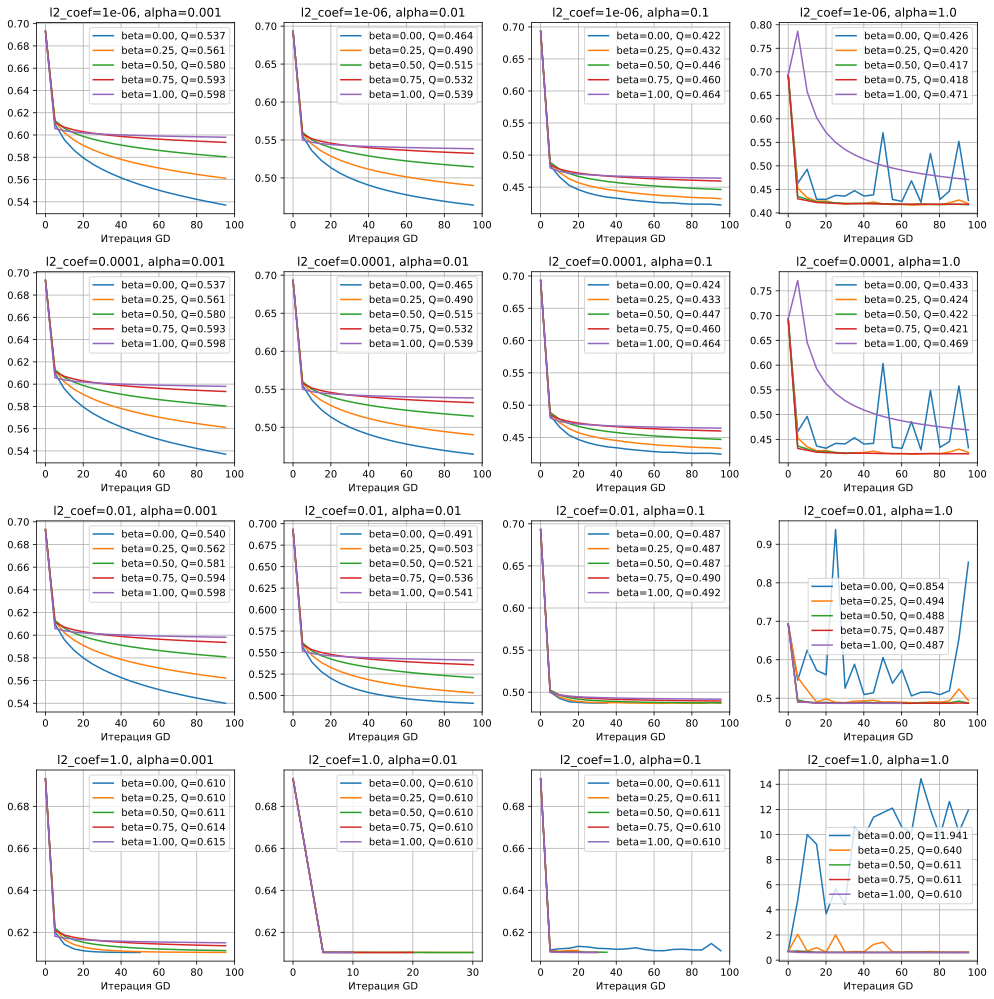

In [26]:
fig, ax = plt.subplots(len(l2_coefs), len(alphas))

#ax[0].set_ylabel('Функция ошибки')
for j, l2_coef in enumerate(l2_coefs):
    for i, alpha in enumerate(alphas):
        for beta in betas:
            ax[j, i].plot(d_exp5[(l2_coef, alpha, beta)][0]['epoch_num'], d_exp5[(l2_coef, alpha, beta)][0]['func'], label=f'beta={beta:.2f}, Q={d_exp5[(l2_coef, alpha, beta)][0]['func'][-1]:.3f}')
            ax[j, i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_xlabel('Итерация GD')

fig.set_size_inches(3.5 * len(alphas), 3.5 * len(l2_coefs) )
fig.tight_layout()
# plt.savefig('alpha_beta_1.svg')
plt.show()


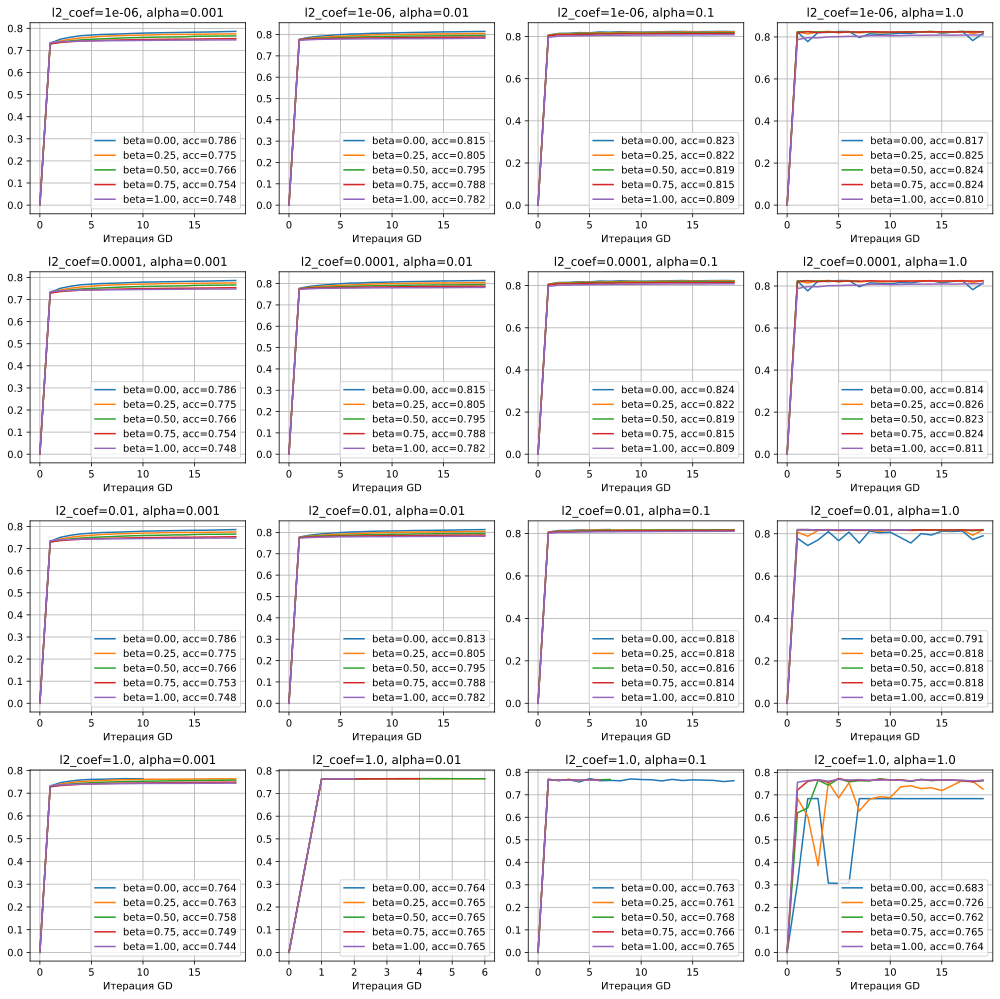

In [27]:
fig, ax = plt.subplots(len(l2_coefs), len(alphas))

#ax[0].set_ylabel('Функция ошибки')
for j, l2_coef in enumerate(l2_coefs):
    for i, alpha in enumerate(alphas):
        for beta in betas:
            ax[j, i].plot(d_exp5[(l2_coef, alpha, beta)][0]['accuracy'], label=f'beta={beta:.2f}, acc={d_exp5[(l2_coef, alpha, beta)][0]['accuracy'][-1]:.3f}')
            ax[j, i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_xlabel('Итерация GD')

fig.set_size_inches(3.5 * len(alphas), 3.5 * len(l2_coefs) )
fig.tight_layout()
# plt.savefig('alpha_beta_1.svg')
plt.show()


In [ ]:
d_exp5_all = dict()

#dfs = [0.001, 0.01, 0.05, 0.1]
dfs = [0.01]
l2_coefs = np.logspace(-6, 0, 4)
alphas = np.logspace(-3, 0, 4)
betas = np.linspace(0, 1, 5)
#batch_sizes = [100, 500, 1_000, 5_000, 10_000]
batch_size = [1_000]

max_iter = 2

# for df in dfs:
#     # vectorizer = CountVectorizer(min_df=df)
#     # X_train = vectorizer.fit_transform(data_train['comment_text'])
#     # X_test = vectorizer.transform(data_test['comment_text'])
#     # print(X_train.shape)
for batch_size in batch_sizes:
    start_time = time.time()
    for l2_coef in l2_coefs:
        for alpha in alphas:
            for beta in betas:
                cls = SGDClassifier(loss_function='binary_logistic', batch_size=batch_size, step_alpha=alpha, step_beta=beta,
                    tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
    
                history = cls.fit(X_train, y_train, w_0=None, trace=True, log_freq=1)
                y_pred = cls.predict(X_test)
                y_probs = cls.predict_proba(X_test)[:, 1]
    
                accuracy = (y_test == y_pred).sum() / len(y_test)
                roc_auc = roc_auc_score(y_test, y_probs)
    
                d_exp5_all[(df, batch_size, l2_coef, alpha, beta)] = history, accuracy, roc_auc
    print(f'done for l2_coef={l2_coef} in {time.time() - start_time:.3f} seconds')


In [73]:
d_exp5_all_to_json = dict()
for (df, batch_size, l2_coef, alpha, beta), val in d_exp5_all.items():
    d_exp5_all_to_json[f"df={df}, batch_size={batch_size}, l2_coef={l2_coef}, alpha={alpha}, beta={beta}"] = val

print('max accuracy:', *max([(key, val[1]) for key, val in d_exp5_all_to_json.items()], key=lambda x: x[1]))
print('max roc-auc:', *max([(key, val[2]) for key, val in d_exp5_all_to_json.items()], key=lambda x: x[1]))
print('min_func value:', *min([(key, val[0]['func'][-1]) for key, val in d_exp5_all_to_json.items()], key=lambda x: x[1]))

with open(f'dump/d_exp5_all_{datetime.now().strftime("m%m-d%d-%H-%M-%S")}.json', 'w') as json_file:
    json.dump(d_exp5_all_to_json, json_file, indent=4, sort_keys=True)

max accuracy: df=0.001, batch_size=1000.0, l2_coef=0.0001, alpha=1.0, beta=0.0 0.8577577868059586
max roc-auc: df=0.001, batch_size=500.0, l2_coef=1e-06, alpha=1.0, beta=0.0 0.9397475577968464
min_func value: df=0.001, batch_size=100.0, l2_coef=1e-06, alpha=1.0, beta=0.25 0.2063629314423915


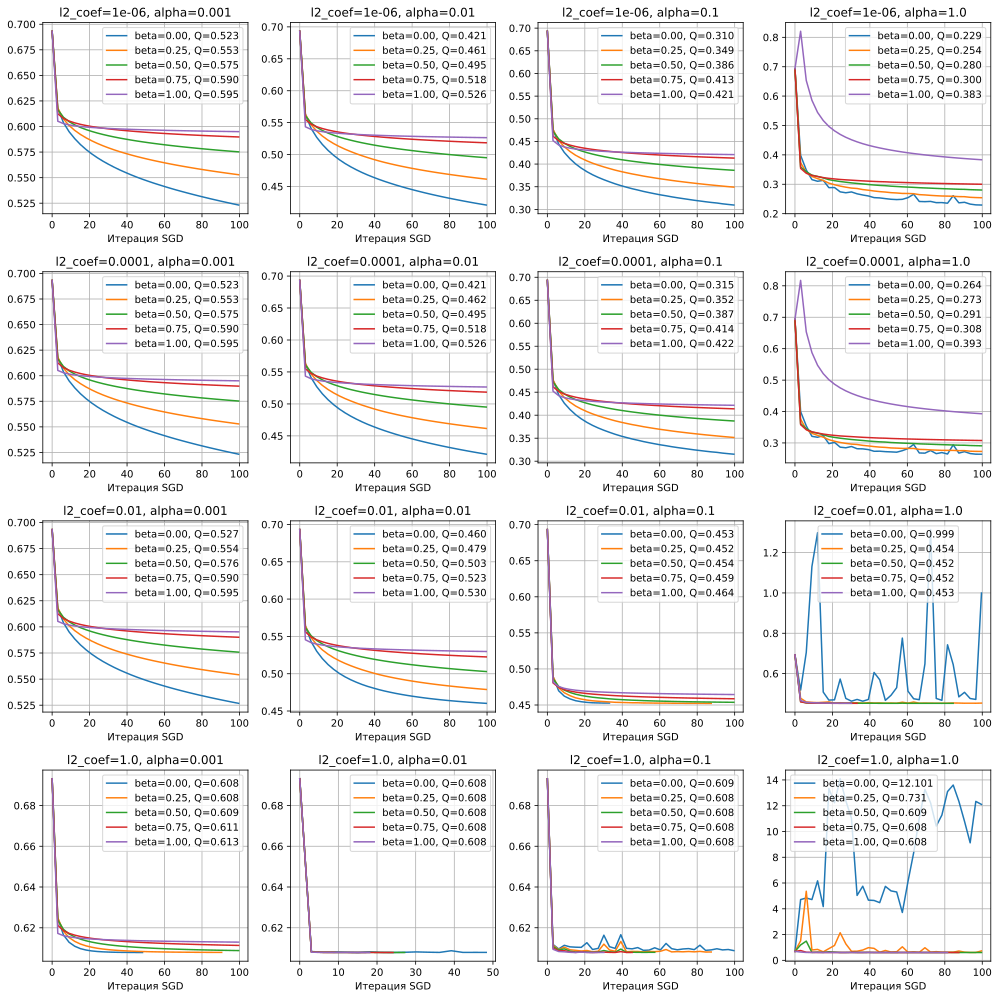

In [74]:
fig, ax = plt.subplots(len(l2_coefs), len(alphas))
df = 0.001
batch_size = 1000
#ax[0].set_ylabel('Функция ошибки')
for j, l2_coef in enumerate(l2_coefs):
    for i, alpha in enumerate(alphas):
        for beta in betas:
            ax[j, i].plot(d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['epoch_num'], 
                          d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['func'], 
                          label=f'beta={beta:.2f}, Q={d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['func'][-1]:.3f}')
            ax[j, i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_xlabel('Итерация SGD')

fig.set_size_inches(3.5 * len(alphas), 3.5 * len(l2_coefs) )
fig.tight_layout()
# plt.savefig('alpha_beta_1.svg')
plt.show()


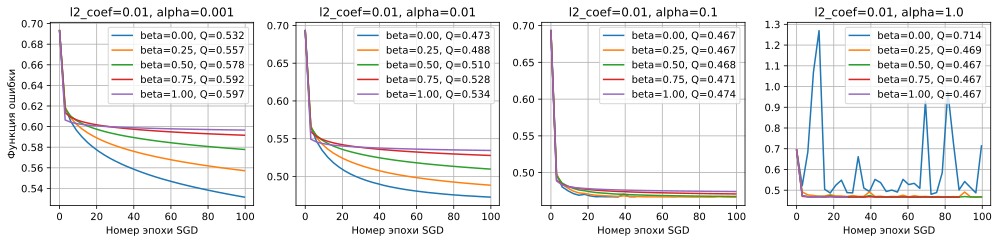

In [200]:
fig, ax = plt.subplots(1, len(alphas))
df = 0.01
batch_size = 1000
l2_coef = 0.01
ax[0].set_ylabel('Функция ошибки')
for i, alpha in enumerate(alphas):
    for beta in betas:
        ax[ i].plot(d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['epoch_num'], 
                      d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['func'], 
                      label=f'beta={beta:.2f}, Q={d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['func'][-1]:.3f}')
        ax[ i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
        ax[ i].grid()
        ax[ i].legend()
        ax[ i].set_xlabel('Номер эпохи SGD')

fig.set_size_inches(3.5 * len(alphas), 3.5  )
fig.tight_layout()
plt.savefig('alpha_beta_func_sgd.svg')
plt.show()


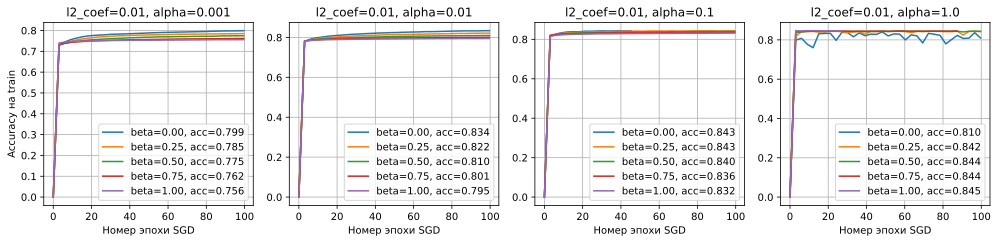

In [201]:
fig, ax = plt.subplots(1, len(alphas))
df = 0.01
batch_size = 1000
l2_coef = 0.01
ax[0].set_ylabel('Accuracy на train')
for i, alpha in enumerate(alphas):
    for beta in betas:
        ax[ i].plot(d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['epoch_num'], 
                      d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['accuracy'], 
                      label=f'beta={beta:.2f}, acc={d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['accuracy'][-1]:.3f}')
        ax[ i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
        ax[ i].grid()
        ax[ i].legend()
        ax[ i].set_xlabel('Номер эпохи SGD')

fig.set_size_inches(3.5 * len(alphas), 3.5  )
fig.tight_layout()
plt.savefig('alpha_beta_acc_sgd.svg')
plt.show()


In [72]:
# with open('dump/d_exp5_all_m11-d16-11-22-13.json', 'r') as json_file:
#     # Загружаем содержимое файла в объект dict
#     data = json.load(json_file)
    
# d_exp5_all = dict()
# for key, val in data.items():
#     pairs = key.split(', ')
#     values = {}
#     for pair in pairs:
#         key, value = pair.split('=')
#         values[key] = float(value) if '.' or 'e' in value else int(value)
#     df = values['df']
#     batch_size = values['batch_size']
#     l2_coef = values['l2_coef']
#     alpha = values['alpha']
#     beta = values['beta']
#     d_exp5_all[(df, batch_size, l2_coef, alpha, beta)] = val

In [ ]:
fig, ax = plt.subplots(1, len(alphas))
df = 0.01
batch_size = 1000
l2_coef = 0.01
ax[0].set_ylabel('Функция ошибки')
for i, alpha in enumerate(alphas):
    for beta in betas:
        ax[ i].plot(d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['epoch_num'], 
                      d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['func'], 
                      label=f'beta={beta:.2f}, Q={d_exp5_all[(df, batch_size, l2_coef, alpha, beta)][0]['func'][-1]:.3f}')
        ax[ i].set_title(f"l2_coef={l2_coef}, alpha={alpha}")
        ax[ i].grid()
        ax[ i].legend()
        ax[ i].set_xlabel('Итерация SGD')

fig.set_size_inches(3.5 * len(alphas), 3.5  )
fig.tight_layout()
plt.savefig('alpha_beta_func_sgd.svg')
plt.show()


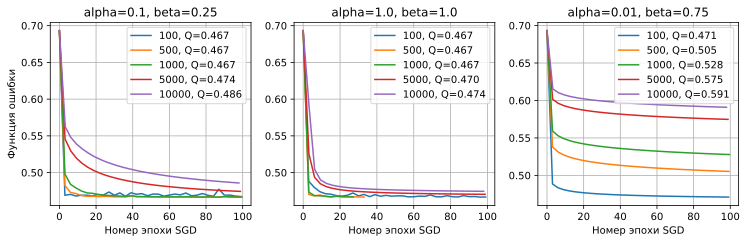

In [202]:
fig, ax = plt.subplots(1, 3)
ax[0].set_ylabel('Функция ошибки')

for i, (alpha, beta) in enumerate([(0.1, 0.25), (1.0, 1.0), (0.01, 0.75)]):
    ax[i].set_title(f"alpha={alpha}, beta={beta}")
    for batch_size in batch_sizes:
        ax[i].plot(d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['epoch_num'],
                  d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['func'],
                  label=f'{batch_size}, Q={d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['func'][-1]:.3f}')
    ax[i].grid()
    ax[i].legend(loc='best')
    ax[i].set_xlabel('Номер эпохи SGD')
#ax[2].legend(loc='best', bbox_to_anchor=(1, 1))

fig.set_size_inches(3.5 * 3, 3.5  )
fig.tight_layout()

plt.savefig('batch_size_sgd_func.svg')
plt.show()

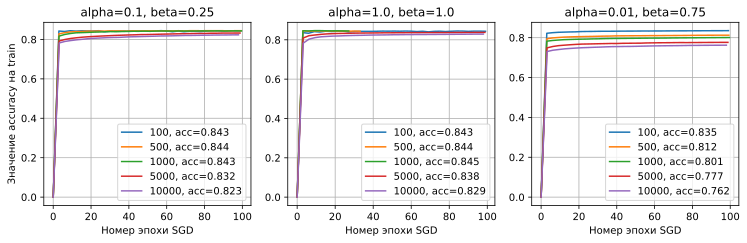

In [203]:
fig, ax = plt.subplots(1, 3)
ax[0].set_ylabel('Значение accuracy на train')

for i, (alpha, beta) in enumerate([(0.1, 0.25), (1.0, 1.0), (0.01, 0.75)]):
    ax[i].set_title(f"alpha={alpha}, beta={beta}")
    for batch_size in batch_sizes:
        ax[i].plot(d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['epoch_num'],
                  d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['accuracy'],
                  label=f'{batch_size}, acc={d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['accuracy'][-1]:.3f}')
    ax[i].grid()
    ax[i].legend(loc='best')
    ax[i].set_xlabel('Номер эпохи SGD')
#ax[2].legend(loc='best', bbox_to_anchor=(1, 1))

fig.set_size_inches(3.5 * 3, 3.5  )
fig.tight_layout()

plt.savefig('batch_size_sgd_acc.svg')
plt.show()

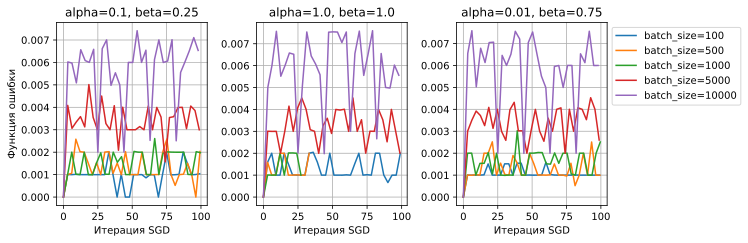

In [120]:
#fig, ax = plt.subplots(1, 3)
#ax[0].set_ylabel('Функция ошибки')
for i, (alpha, beta) in enumerate([(0.1, 0.25), (1.0, 1.0), (0.01, 0.75)]):
    #ax[i].set_title(f"alpha={alpha}, beta={beta}")
    for batch_size in batch_sizes:
        #ax[i].plot(d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['epoch_num'],
        #         d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['time'],
        #          label=f'batch_size={batch_size}')
    #ax[i].grid()
    #ax[i].legend()
    #ax[i].set_xlabel('Итерация SGD')
#ax[2].legend(loc='best', bbox_to_anchor=(1, 1))
#fig.set_size_inches(3.5 * 3, 3.5  )
#fig.tight_layout()

In [132]:
for i, (alpha, beta) in enumerate([(0.1, 0.25), (1.0, 1.0), (0.01, 0.75)]):
    for batch_size in batch_sizes:
        print(f'alpha={alpha}, beta={beta}, batch_size={batch_size} \t {np.array(d_exp5_all[(0.01, batch_size, 0.01, alpha, beta)][0]['time']).sum()}')

alpha=0.1, beta=0.25, batch_size=100 	 0.03241133689880371
alpha=0.1, beta=0.25, batch_size=500 	 0.044989585876464844
alpha=0.1, beta=0.25, batch_size=1000 	 0.051528215408325195
alpha=0.1, beta=0.25, batch_size=5000 	 0.11011934280395508
alpha=0.1, beta=0.25, batch_size=10000 	 0.17641520500183105
alpha=1.0, beta=1.0, batch_size=100 	 0.043985843658447266
alpha=1.0, beta=1.0, batch_size=500 	 0.014614105224609375
alpha=1.0, beta=1.0, batch_size=1000 	 0.013036727905273438
alpha=1.0, beta=1.0, batch_size=5000 	 0.10468101501464844
alpha=1.0, beta=1.0, batch_size=10000 	 0.1827101707458496
alpha=0.01, beta=0.75, batch_size=100 	 0.036286115646362305
alpha=0.01, beta=0.75, batch_size=500 	 0.04314756393432617
alpha=0.01, beta=0.75, batch_size=1000 	 0.05335688591003418
alpha=0.01, beta=0.75, batch_size=5000 	 0.10952544212341309
alpha=0.01, beta=0.75, batch_size=10000 	 0.18064570426940918


In [166]:
np.random.seed(42)
w_0_list = [
    ('zero', np.zeros(X_train.shape[1])),
    ('N(0, 0.01)', np.random.randn(X_train.shape[1]) * 0.01),
    ('N(0, 1)', np.random.randn(X_train.shape[1])),
    ('U(-0.1, 0.1)', np.random.uniform(-0.1, 0.1, size=X_train.shape[1])),
    ('U(-1, 1)', np.random.uniform(-1, 1, size=X_train.shape[1]))
]
d_w0_exp5 = dict()
alpha_beta = [(0.1, 0.25), (0.1, 1.0), (1, 0.75)]

for i, (alpha, beta) in enumerate(alpha_beta):
    print(f"alpha={alpha}, beta={beta}")
    for name, w_0 in w_0_list:
        start_time = time.time()
        cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alpha, step_beta=beta,
            tolerance=1e-5, max_iter=100, l2_coef=0.01)
        
        history = cls.fit(X_train, y_train, w_0=w_0, trace=True, log_freq=1)
        y_pred = cls.predict(X_test)
        y_probs = cls.predict_proba(X_test)[:, 1]
        
        accuracy = (y_test == y_pred).sum() / len(y_test)
        roc_auc = roc_auc_score(y_test, y_probs)
        
        d_w0_exp5[(alpha, beta, name)] = history, accuracy, roc_auc
        print(f"{time.time() - start_time}, \t {name}, \t {accuracy}")

alpha=0.1, beta=0.25
4.334375381469727, 	 zero, 	 0.7965757399883924
3.5498406887054443, 	 N(0, 0.01), 	 0.7965757399883924
9.657009840011597, 	 N(0, 1), 	 0.7973495840588122
10.07137417793274, 	 U(-0.1, 0.1), 	 0.801363900174115
10.164856910705566, 	 U(-1, 1), 	 0.7993809247436642
alpha=0.1, beta=1.0
4.858985900878906, 	 zero, 	 0.7987038111820468
6.13671612739563, 	 N(0, 0.01), 	 0.7988972721996518
7.170811653137207, 	 N(0, 1), 	 0.7996711162700716
2.245643138885498, 	 U(-0.1, 0.1), 	 0.8017024569549236
7.342410564422607, 	 U(-1, 1), 	 0.7993809247436642
alpha=1, beta=0.75
4.982753276824951, 	 zero, 	 0.802186109498936
5.203529357910156, 	 N(0, 0.01), 	 0.802186109498936
5.909067392349243, 	 N(0, 1), 	 0.8020893789901334
4.6930506229400635, 	 U(-0.1, 0.1), 	 0.8021377442445348
5.4790496826171875, 	 U(-1, 1), 	 0.802186109498936


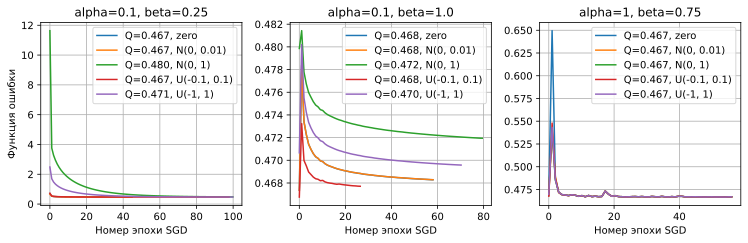

In [204]:
fig, ax = plt.subplots(1, 3)
ax[0].set_ylabel('Функция ошибки')
for i, (alpha, beta) in enumerate(alpha_beta):
    ax[i].set_title(f"alpha={alpha}, beta={beta}")
    for name, w_0 in w_0_list:
        ax[i].plot(d_w0_exp5[(alpha, beta, name)][0]['epoch_num'],
                  d_w0_exp5[(alpha, beta, name)][0]['func'],
                  label=f'Q={d_w0_exp5[(alpha, beta, name)][0]['func'][-1]:.3f}, {name}')
    ax[i].grid()
    ax[i].legend(loc='best')
    ax[i].set_xlabel('Номер эпохи SGD')

fig.set_size_inches(3.5 * 3, 3.5)
fig.tight_layout()

plt.savefig('w_0_sgd_func.svg')
plt.show()

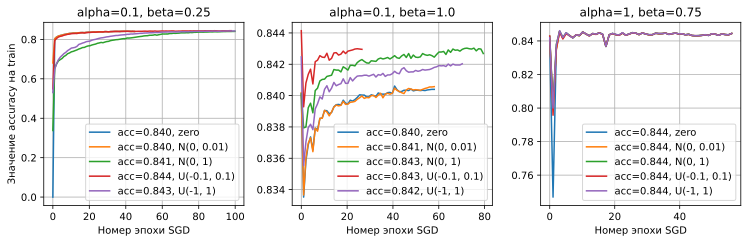

In [205]:
fig, ax = plt.subplots(1, 3)
ax[0].set_ylabel('Значение accuracy на train')
for i, (alpha, beta) in enumerate(alpha_beta):
    ax[i].set_title(f"alpha={alpha}, beta={beta}")
    for name, w_0 in w_0_list:
        ax[i].plot(d_w0_exp5[(alpha, beta, name)][0]['epoch_num'],
                  d_w0_exp5[(alpha, beta, name)][0]['accuracy'],
                  label=f'acc={d_w0_exp5[(alpha, beta, name)][0]['accuracy'][-1]:.3f}, {name}')
    ax[i].grid()
    ax[i].legend(loc='best')
    ax[i].set_xlabel('Номер эпохи SGD')

fig.set_size_inches(3.5 * 3, 3.5)
fig.tight_layout()

plt.savefig('w_0_sgd_acc.svg')
plt.show()

## Эксперимент 6

In [182]:
max_iter_GD = 1000
max_iter_SGD = 20
batch_size = 1000

alpha = 1
beta = 0.25
l2_coef = 0.01

cls_GD = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta,
                tolerance=1e-5, max_iter=max_iter_GD, l2_coef=l2_coef)
history_GD = cls_GD.fit(X_train, y_train, trace=True)
y_pred_GD = cls_GD.predict(X_test)
accuracy_GD = (y_pred_GD == y_test).sum() / len(y_test)
print(f"accuracy_GD = {accuracy_GD}")


cls_SGD = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alpha, step_beta=beta,
                tolerance=1e-5, max_iter=max_iter_SGD, l2_coef=l2_coef)
history_SGD = cls_SGD.fit(X_train, y_train, trace=True)
y_pred_SGD = cls_SGD.predict(X_test)
accuracy_SGD = (y_pred_SGD == y_test).sum() / len(y_test)
print(f"accuracy_SGD = {accuracy_SGD}")

accuracy_GD = 0.7961888179531824
accuracy_SGD = 0.7899013348810214


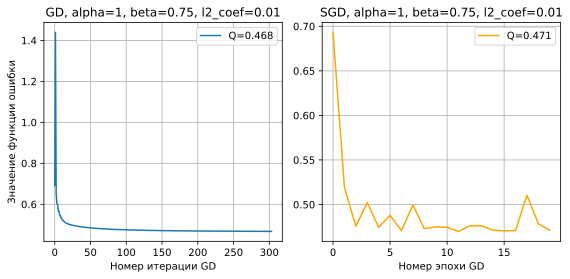

In [227]:
fig, ax = plt.subplots(1, 2)
ax[0].set_ylabel('Значение функции ошибки')

ax[0].set_title(f'GD, alpha={alpha}, beta={beta}, l2_coef={l2_coef}')
ax[0].plot(history_GD['func'], label=f"Q={history_GD['func'][-1]:.3f}")
ax[0].set_xlabel('Номер итерации GD')
ax[0].grid()
ax[0].legend()

ax[1].set_title(f'SGD, alpha={alpha}, beta={beta}, l2_coef={l2_coef}')
ax[1].plot(history_SGD['func'], label=f"Q={history_SGD['func'][-1]:.3f}", color='orange')
ax[1].set_xlabel('Номер эпохи GD')
ax[1].grid()
ax[1].legend()
fig.set_size_inches(4 * 2, 4)
fig.tight_layout()

plt.savefig('GD_vs_SGD_func.svg')
plt.show()

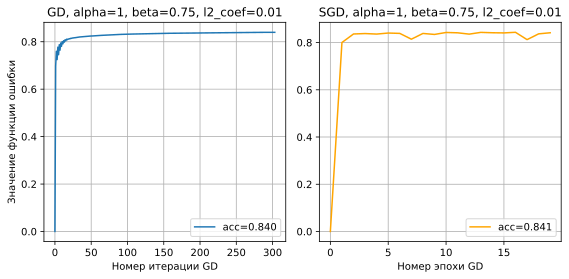

In [228]:
fig, ax = plt.subplots(1, 2)
ax[0].set_ylabel('Значение функции ошибки')

ax[0].set_title(f'GD, alpha={alpha}, beta={beta}, l2_coef={l2_coef}')
ax[0].plot(history_GD['accuracy'], label=f"acc={history_GD['accuracy'][-1]:.3f}")
ax[0].set_xlabel('Номер итерации GD')
ax[0].grid()
ax[0].legend()

ax[1].set_title(f'SGD, alpha={alpha}, beta={beta}, l2_coef={l2_coef}')
ax[1].plot(history_SGD['accuracy'], label=f"acc={history_SGD['accuracy'][-1]:.3f}", color='orange')
ax[1].set_xlabel('Номер эпохи GD')
ax[1].grid()
ax[1].legend()
fig.set_size_inches(4 * 2, 4)
fig.tight_layout()

plt.savefig('GD_vs_SGD_acc.svg')
plt.show()

In [231]:
sum(history_GD['time']) / sum(history_SGD['time'])

108.60849158940685

## Эксперимент 7

In [447]:
import nltk
import re

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

stop_words = set(stopwords.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Олег\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [497]:
def get_wordnet_pos(treebank_tag):
    """Преобразует теги POS из nltk.pos_tag в теги, которые понимает WordNetLemmatizer."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # По умолчанию возвращаем NOUN

def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub("[^a-zA-Z]", " ", sentence.lower())
    tokenized_sent = nltk.word_tokenize(sentence)
    pos_tagged = [(word, get_wordnet_pos(tag)) for word, tag in nltk.pos_tag(tokenized_sent)]
    return " ".join([
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_tagged if word not in stop_words
    ])


In [422]:
def text_editor(s: str):
    text = re.sub("[^a-zA-Z]", " ", s.lower())
    text = nltk.word_tokenize(text, language="english")
    text = [lemmatize.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [501]:
data_train['lemm_text'] = data_train['comment_text'].apply(simple_lemmatizer)
data_test['lemm_text'] = data_test['comment_text'].apply(simple_lemmatizer)

In [647]:
min_df = 1

vectorizer1 = CountVectorizer(min_df=min_df)

X_train1 = vectorizer1.fit_transform(data_train['comment_text'])
X_test1 = vectorizer1.transform(data_test['comment_text'])
print('without:', X_train1.shape)

vectorizer2 = CountVectorizer(min_df=min_df)
X_train2 = vectorizer2.fit_transform(data_train['lemm_text'])
X_test2 = vectorizer2.transform(data_test['lemm_text'])
print('with:', X_train2.shape)

without: (52061, 90764)
with: (52061, 74755)


In [741]:
max_iter_GD = 1000
alpha = 0.1
beta = 0.01
l2_coef = 0.01

cls1 = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta,
                tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
history1 = cls1.fit(X_train1, y_train, trace=True)
y_pred1 = cls1.predict(X_test1)
accuracy1 = (y_pred1 == y_test).sum() / len(y_test)
print(f"accuracy1 = {accuracy1}")

cls2 = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta,
                tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
history2 = cls2.fit(X_train2, y_train, trace=True)
y_pred2 = cls2.predict(X_test2)
accuracy2 = (y_pred2 == y_test).sum() / len(y_test)
print(f"accuracy2 = {accuracy2}")


ValueError: operands could not be broadcast together with shapes (52061,) (36442,) 

In [746]:
y_train

array([-1, -1, -1, ...,  1,  1,  1])

In [747]:
import pandas as pd
from sklearn.model_selection import train_test_split

param_grid = [
    (50, 0.1, 0.01, 0.01),
    (50, 0.05, 0.02, 0.02),
    (50, 0.25, 0.25, 0.1),
    (50, 1, 0, 0.1),
]

# Инициализация списка для хранения результатов
results = []
for min_df in [1]:
    vectorizer1 = CountVectorizer(min_df=min_df)
    vectorizer2 = CountVectorizer(min_df=min_df)

    # Векторизация данных
    X_1 = vectorizer1.fit_transform(data_train['comment_text'])
    #X_test1 = vectorizer1.transform(data_test['comment_text'])
    
    X_2 = vectorizer2.fit_transform(data_train['lemm_text'])
    #X_test2 = vectorizer2.transform(data_test['lemm_text'])
    X_train1, X_val1, y_train1, y_val1 = train_test_split(X_1, y_train, test_size=0.3, random_state=42)
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_2, y_train, test_size=0.3, random_state=42)

    start_time = time.time()
    for max_iter, alpha, beta, l2_coef in param_grid:
        print(f"max_iter={max_iter}, alpha={alpha}, beta={beta}, l2_coef={l2_coef}:")
        # Создание и обучение моделей
        cls1 = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alpha, step_beta=beta,
                            tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
        history1 = cls1.fit(X_train1, y_train1, trace=True)
        y_pred1 = cls1.predict(X_val1)
        accuracy1 = accuracy_score(y_val1, y_pred1)
    
        cls2 = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alpha, step_beta=beta,
                            tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
        history2 = cls2.fit(X_train2, y_train2, trace=True)
        y_pred2 = cls2.predict(X_val2)
        accuracy2 = accuracy_score(y_val2, y_pred2)
    
        # Сохранение результатов
        results.append({
            'min_df': min_df,
            'max_iter_GD': max_iter,
            'alpha': alpha,
            'beta': beta,
            'l2_coef': l2_coef,
            'accuracy1': accuracy1,
            'accuracy2': accuracy2,
            'history1': history1,
            'history2': history2
        })
        print(accuracy1, accuracy2)
    print(f"done fot {min_df} in {time.time() - start_time} seconds")

# Создание DataFrame из результатов
results_df = pd.DataFrame(results)

# Вывод результатов
print(results_df)

max_iter=50, alpha=0.1, beta=0.01, l2_coef=0.01:
0.8601062808118317 0.8723990012164671
max_iter=50, alpha=0.05, beta=0.02, l2_coef=0.02:
0.8499263717267431 0.8628593379857865
max_iter=50, alpha=0.25, beta=0.25, l2_coef=0.1:
0.8279659389205455 0.8364812087841731
max_iter=50, alpha=1, beta=0, l2_coef=0.1:
0.6184134707727768 0.8292464306293617
done fot 1 in 14.99943995475769 seconds
   min_df  max_iter_GD  alpha  beta  l2_coef  accuracy1  accuracy2  \
0       1           50   0.10  0.01     0.01   0.860106   0.872399   
1       1           50   0.05  0.02     0.02   0.849926   0.862859   
2       1           50   0.25  0.25     0.10   0.827966   0.836481   
3       1           50   1.00  0.00     0.10   0.618413   0.829246   

                                            history1  \
0  {'epoch_num': [0, 1.0274408649360627, 2.054881...   
1  {'epoch_num': [0, 1.0274408649360627, 2.054881...   
2  {'epoch_num': [0, 1.0274408649360627, 2.054881...   
3  {'epoch_num': [0, 1.0274408649360627, 2

In [748]:
results_df['time1'] = results_df['history1'].apply(lambda x: sum(x['time']))
results_df['time2'] = results_df['history2'].apply(lambda x: sum(x['time']))

In [749]:
results_df[['min_df',  'alpha', 'beta', 'l2_coef', 'time1', 'time2', 'accuracy1', 'accuracy2']]

min_df  alpha  beta  l2_coef     time1     time2  accuracy1  accuracy2
0       1   0.10  0.01     0.01  0.039635  0.037847   0.860106   0.872399
1       1   0.05  0.02     0.02  0.054764  0.048856   0.849926   0.862859
2       1   0.25  0.25     0.10  0.014099  0.006971   0.827966   0.836481
3       1   1.00  0.00     0.10  0.060769  0.043400   0.618413   0.829246

In [683]:
results_df['time2'].mean()

np.float64(0.05742529034614563)

In [630]:
# def silly_func(s):
#     return any(x in s for x in ['fuck', 'suck', 'bitch', 'cunt', 'slut', 'ass', 'asshole',
#                                 'bullshit', 'pussy', 'dick', 'shit', 'freak', 
#                                 'damn', 'piss', 'shit', 'nigga', 'nigger', 'jerk'])

# silly_train = data_train['lemm_text'].apply(silly_func)
# silly_test = data_test['lemm_text'].apply(silly_func)
# print((silly_test == data_test['is_toxic']).sum() / len(silly_test))
# print((silly_train == data_train['is_toxic']).sum() / len(silly_train))

## Эксперимент 8

In [692]:
data_train

Unnamed: 0                                       comment_text  \
0               0  explanation why the edits made under my userna...   
1               1  d aww  he matches this background colour i m s...   
2               2  hey man  i m really not trying to edit war  it...   
3               3    more i can t make any real suggestions on im...   
4               4  you  sir  are my hero  any chance you remember...   
...           ...                                                ...   
52056      159494      our previous conversation   you fucking sh...   
52057      159514                  you are a mischievious pubic hair   
52058      159541  your absurd edits   your absurd edits on great...   
52059      159546     hey listen don t you ever     delete my edi...   
52060      159554  and i m going to keep posting the stuff u dele...   

       is_toxic                                          lemm_text  
0         False  explanation edits make username hardcore metal...  
1         False  aww match background colour seemingly stick ta...  
2         False  hey edit guy constantly remove relevant inform...  
3         False  make real suggestion improvement wonder sectio...  
4         False                      sir hero chance remember page  
...         ...                                                ...  
52056      True  previous conversation fuck shit eating liberal...  
52057      True                            mischievious pubic hair  
52058      True  absurd edits absurd edits great white shark to...  
52059      True  hey listen delete edits annoy wwe roster confi...  
52060      True  post stuff delete fuck site close fun stupid a...  

[52061 rows x 4 columns]

In [693]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer1 = CountVectorizer(min_df=1)
X_train = vectorizer1.fit_transform(data_train['lemm_text'])
X_test = vectorizer1.transform(data_test['lemm_text'])

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)
print(X_train_tfidf.shape)

(52061, 74755)


In [752]:
import pandas as pd

param_grid = [
    (100, 0.05, 0.02, 0.02),
]

# Инициализация списка для хранения результатов
results = []
for min_df in [1e-5, 2e-5, 5e-5, 1e-4, 1e-3, 1e-2]:
    start_time = time.time()
    vectorizer = CountVectorizer(min_df=min_df)

    X = vectorizer.fit_transform(data_train['lemm_text'])
    #X_test = vectorizer.transform(data_test['lemm_text'])

    tfidf_transformer = TfidfTransformer(norm=None)
    
    X_tfidf = tfidf_transformer.fit_transform(X)
    #X_test_tfidf = tfidf_transformer.transform(X_test)
    print(f"done for {min_df} in {time.time() - start_time} seconds")
    X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X, y_train, test_size=0.3, random_state=42)

    X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_tfidf, y_train, test_size=0.3, random_state=42)
    for max_iter, alpha, beta, l2_coef in param_grid:
        print(f"max_iter={max_iter}, alpha={alpha}, beta={beta}, l2_coef={l2_coef}:")
        # Создание и обучение моделей
        cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alpha, step_beta=beta,
                            tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
        history = cls.fit(X_train_1, y_train_1, trace=True)
        y_pred = cls.predict(X_val_1)
        accuracy = accuracy_score(y_val_1, y_pred)
    
        cls_tfidf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=alpha, step_beta=beta,
                            tolerance=1e-5, max_iter=max_iter, l2_coef=l2_coef)
        history_tfidf = cls_tfidf.fit(X_train_tfidf, y_train_tfidf, trace=True)
        y_pred_tfidf = cls_tfidf.predict(X_val_tfidf)
        accuracy_tfidf = accuracy_score(y_val_tfidf, y_pred_tfidf)
    
        # Сохранение результатов
        results.append({
            'min_df': min_df,
            'max_iter_GD': max_iter,
            'alpha': alpha,
            'beta': beta,
            'l2_coef': l2_coef,
            'accuracy': accuracy,
            'accuracy_tfidf': accuracy_tfidf,
            'time': sum(history['time']),
            'time_tfidf': sum(history_tfidf['time'])
        })
        print(accuracy, accuracy_tfidf)
    

# Создание DataFrame из результатов
results_df = pd.DataFrame(results)

# Вывод результатов
print(results_df)

done for 1e-05 in 1.2575266361236572 seconds
max_iter=100, alpha=0.05, beta=0.02, l2_coef=0.02:
0.8636916575965171 0.8989051795889622
done for 2e-05 in 1.2720706462860107 seconds
max_iter=100, alpha=0.05, beta=0.02, l2_coef=0.02:
0.8636276330110763 0.8990332287598438
done for 5e-05 in 1.2134501934051514 seconds
max_iter=100, alpha=0.05, beta=0.02, l2_coef=0.02:
0.863371534669313 0.8987131058326397
done for 0.0001 in 1.2418465614318848 seconds
max_iter=100, alpha=0.05, beta=0.02, l2_coef=0.02:
0.8620910429604969 0.8969844420257379
done for 0.001 in 1.1121652126312256 seconds
max_iter=100, alpha=0.05, beta=0.02, l2_coef=0.02:
0.8554965106600935 0.8862283116716819
done for 0.01 in 1.1450624465942383 seconds
max_iter=100, alpha=0.05, beta=0.02, l2_coef=0.02:
0.7891670401434151 0.8040847685511237
    min_df  max_iter_GD  alpha  beta  l2_coef  accuracy  accuracy_tfidf  \
0  0.00001          100   0.05  0.02     0.02  0.863692        0.898905   
1  0.00002          100   0.05  0.02     0.02  

In [786]:
results_df[['min_df', 'accuracy', 'accuracy_tfidf','time','time_tfidf']]

min_df  accuracy  accuracy_tfidf      time  time_tfidf
0  0.00001  0.863692        0.898905  0.045594    0.055363
1  0.00002  0.863628        0.899033  0.025229    0.019038
2  0.00005  0.863372        0.898713  0.033679    0.029571
3  0.00010  0.862091        0.896984  0.019577    0.027835
4  0.00100  0.855497        0.886228  0.015085    0.023822
5  0.01000  0.789167        0.804085  0.013309    0.013020

## Эксперимент 9

In [870]:
vectorizer = CountVectorizer(min_df=2e-5)
tfidf_transformer = TfidfTransformer(norm=None)

X = vectorizer.fit_transform(data_train['lemm_text']) 
X = tfidf_transformer.fit_transform(X)

y = (data_train['is_toxic'] * 2 - 1).to_numpy()

X_test = vectorizer.transform(data_test['lemm_text'])
y_test = (data_test['is_toxic'] * 2 - 1).to_numpy()
print(X.shape)


(52061, 29748)


In [871]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [813]:
d = dict()

In [843]:
alpha_list = np.linspace(0.055, 0.075, 5)
beta_list = [0, 0.0001, 0.001]
l2_score_list = np.logspace(-3, 0, 2)

for alpha in alpha_list:
    for beta in beta_list:
        for l2_score in l2_score_list:
            cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                            step_alpha=alpha, step_beta=beta,
                            tolerance=1e-5, max_iter=100, l2_coef=l2_coef)
            history = cls.fit(X_train, y_train, trace=True)
            y_pred = cls.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            d[(alpha, beta, l2_score)] = accuracy
            print(f"acc={accuracy} \t alpha={alpha}, beta={beta}, l2_score={l2_score}")

acc=0.8985850566617581 	 alpha=0.055, beta=0, l2_score=0.001
acc=0.8985850566617581 	 alpha=0.055, beta=0, l2_score=1.0
acc=0.8985850566617581 	 alpha=0.055, beta=0.0001, l2_score=0.001
acc=0.8985850566617581 	 alpha=0.055, beta=0.0001, l2_score=1.0
acc=0.8985850566617581 	 alpha=0.055, beta=0.001, l2_score=0.001
acc=0.8985850566617581 	 alpha=0.055, beta=0.001, l2_score=1.0
acc=0.8998015237851335 	 alpha=0.06, beta=0, l2_score=0.001
acc=0.8998015237851335 	 alpha=0.06, beta=0, l2_score=1.0
acc=0.8998015237851335 	 alpha=0.06, beta=0.0001, l2_score=0.001
acc=0.8998015237851335 	 alpha=0.06, beta=0.0001, l2_score=1.0
acc=0.8990972533452846 	 alpha=0.06, beta=0.001, l2_score=0.001
acc=0.8990972533452846 	 alpha=0.06, beta=0.001, l2_score=1.0
acc=0.8992253025161662 	 alpha=0.065, beta=0, l2_score=0.001
acc=0.8992253025161662 	 alpha=0.065, beta=0, l2_score=1.0
acc=0.8990972533452846 	 alpha=0.065, beta=0.0001, l2_score=0.001
acc=0.8990972533452846 	 alpha=0.065, beta=0.0001, l2_score=1.0


In [844]:
print(
    *sorted([z for z in d.items()], key=lambda x: -x[1])[:10], sep='\n'
)

((0.06, 0, np.float64(0.001)), 0.8998015237851335)
((0.06, 0, np.float64(0.01)), 0.8998015237851335)
((0.06, 0, np.float64(0.1)), 0.8998015237851335)
((0.06, 0, np.float64(1.0)), 0.8998015237851335)
((0.06, 0.0001, np.float64(0.001)), 0.8998015237851335)
((0.06, 0.0001, np.float64(0.01)), 0.8998015237851335)
((0.06, 0.0001, np.float64(0.1)), 0.8998015237851335)
((0.06, 0.0001, np.float64(1.0)), 0.8998015237851335)
((0.05, 0.01, 0.1), 0.8996094500288111)
((0.04, 0.0001, np.float64(0.001)), 0.8996094500288111)


In [857]:
d2 = dict()

In [874]:
for (alpha, beta, l2_score), acc_val in sorted([z for z in d.items()], key=lambda x: -x[1])[:100]:
    cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                        step_alpha=alpha, step_beta=beta,
                        tolerance=1e-5, max_iter=100, l2_coef=l2_coef)
    history = cls.fit(X, y, trace=True)
    y_pred = cls.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    d2[(alpha, beta, l2_score)] = accuracy
    print(f"acc={accuracy} \t alpha={alpha}, beta={beta}, l2_score={l2_score}")

acc=0.8599825885084156 	 alpha=0.06, beta=0, l2_score=0.001
acc=0.8599825885084156 	 alpha=0.06, beta=0, l2_score=0.01
acc=0.8599825885084156 	 alpha=0.06, beta=0, l2_score=0.1
acc=0.8599825885084156 	 alpha=0.06, beta=0, l2_score=1.0


KeyboardInterrupt: 

In [1008]:
vectorizer = CountVectorizer(min_df=2e-5)
tfidf_transformer = TfidfTransformer(norm=None)

X = vectorizer.fit_transform(data_train['lemm_text']) 
X = tfidf_transformer.fit_transform(X)

y = (data_train['is_toxic'] * 2 - 1).to_numpy()

X_test = vectorizer.transform(data_test['lemm_text'])
#X_test = tfidf_transformer.transform(X_test)
y_test = (data_test['is_toxic'] * 2 - 1).to_numpy()
print(X.shape)

cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                    step_alpha=0.06, step_beta=0.0001,
                    tolerance=1e-5, max_iter=100, l2_coef=0.01)
history = cls.fit(X, y, w_0=np.random.uniform(-0.1, 0.1, X.shape[1]), trace=True)
#history = cls.fit(X, y, w_0=np.random.randn(X.shape[1]) * 0.1, trace=True)
y_pred = cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#d2[(alpha, beta, l2_score)] = accuracy

(52061, 29748)
0.8617237376668602


In [954]:

data_test_origin = pd.read_csv('toxic_test.csv')
data_test['origin'] = data_test_origin['comment_text']

In [992]:
FP = data_test[(y_test != y_pred) & (y_pred == 1)]
print(len(FP))
FP_sample = FP.sample(10, random_state=1)
FP_sample

1925


Unnamed: 0                                       comment_text  \
392           392  agreed  it is stupid to say that any malfoy is...   
13082       13082  i ll give you that  unfortunately  there are a...   
12450       12450         yea   kevin is a bit annoying  lol i lo...   
9915         9915                           delete patent nonesense    
2553         2553  oh zut   it should be franz schrönghamer heimd...   
5268         5268         ok   i don t like spreading this crap b...   
3206         3206       uh   im not quite sure the latter poster ...   
10567       10567    juggernaut bitch deleted       http   en wik...   
8806         8806    it is merely the truth   please stop editing...   
12984       12984         delusion       holy misguided valour  yes    

       is_toxic                                          lemm_text  \
392       False                         agree stupid malfoy albino   
13082     False  give unfortunately lot stupid world large word...   
12450     False  yea kevin bit annoy love angelina funny chloe ...   
9915      False                            delete patent nonesense   
2553      False  zut franz schr nghamer heimdal idiot sort give...   
5268      False             spread crap part bio death wish attack   
3206      False  uh latter poster understand break mean ridicul...   
10567     False  juggernaut bitch delete http wikipedia org w i...   
8806      False            truth stop editing fact coincide agenda   
12984     False                      delusion holy misguide valour   

                                                  origin  
392    Agreed, it is stupid to say that any Malfoy is...  
13082  I'll give you that. Unfortunately, there are a...  
12450  " \n :: Yea...Kevin is a bit annoying. Lol i l...  
9915                            Delete patent nonesense!  
2553   oh zut \n It should be Franz Schrönghamer-Heim...  
5268   " \n\n ::Ok.. I don't like spreading this crap...  
3206   " \n\n Uh...im not quite sure the latter poste...  
10567  ==Juggernaut Bitch deleted == \n\n http://en.w...  
8806   , it is merely the truth.  Please stop editing...  
12984    == Delusion == \n\n Holy misguided valour. Yes.

In [999]:
FN = data_test[(y_test != y_pred) & (y_pred == -1)]
print(len(FN))
FN_sample = FN.sample(10, random_state=26)
FN_sample

588


Unnamed: 0                                       comment_text  \
4375         4375     racist ungrateful bunch       those who run...   
18036       36877          joe s gonna kill you       should ther...   
8049         8049       ahaha  no i m bloody not  i had a bad fee...   
18044       36999     9 april 2008  utc           i m sorry  but ...   
19838       55060                             i m rick james  b1tch    
2521         2521         ah  darnit   and now you ve reminded me...   
18424       41006       i also took offense for the   dumbass   r...   
19685       53662  you know  it would be best if you were to cons...   
16012       16201   don t be silly   you are making the claim  so...   
12066       12066  you vandalized the daylight savings article  m...   

       is_toxic                                          lemm_text  \
4375       True  racist ungrateful bunch run country region bun...   
18036      True  joe gon kill mention infamous chant f joe curi...   
8049       True  ahaha bloody feel day vanessa darren leave cha...   
18044      True  april utc sorry thing knowledge legal system w...   
19838      True                                   rick james b tch   
2521       True  darnit remind add equine tourette tourette syn...   
18424      True  offense dumbass remark language civil wikipedi...   
19685      True  consider probation edit article provide conten...   
16012      True  silly make claim prove reputable source believ...   
12066      True     vandalize daylight saving article motherfucker   

                                                  origin  
4375   == Racist ungrateful bunch == \n\n Those who r...  
18036  " \n\n == Joe's gonna kill you == \n\n Should ...  
8049   " \n :Ahaha! No I'm bloody not! I had a bad fe...  
18044  ", 9 April 2008 (UTC) \n ::::...I'm sorry, but...  
19838                             I'm rick james, B1tch!  
2521   " \n :: ah, darnit.  And now you've reminded m...  
18424  " \n\n I also took offense for the ""dumbass""...  
19685  You know, it would be best if you were to cons...  
16012  :Don't be silly.  You are making the claim, so...  
12066  You vandalized the daylight savings article, m...

In [1000]:

print('--' * 50)
for orig, lemm in zip(FN_sample['origin'], FN_sample['lemm_text']):
    print(orig)
    
    print('---> ')
    print([x for x in lemm.split()])
    print('--' * 50)

----------------------------------------------------------------------------------------------------
== Racist ungrateful bunch == 

 Those who run this country ( and some of the others in the region ) are a bunch of pigs!! Talk of themselves as followers of Islam and followers of the Quran! Someone (Hmmm Iran or US) should invade this country.. Lets see if these pigs fight the invaders or defect... or surrender.... or,  wait, probably rope in some of the expats to fight, for a minimum wage? I mean, some of the expats are brown too.. so they could pass as being 'Emirati'... and after the war, the expats can get royal treatment... and perhaps get offered the glorious ( and 2nd class ) UAE citizenship, which means that expats can now stay and live in the country for good... just that they wont be classed as the 'original' citizens.. pfftttt.. this part of the world is a joke!
---> 
['racist', 'ungrateful', 'bunch', 'run', 'country', 'region', 'bunch', 'pig', 'talk', 'follower', 'islam', 

## Улучшения

In [1010]:
vectorizer = CountVectorizer(min_df=2e-5, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm=None)

X = vectorizer.fit_transform(data_train['lemm_text']) 
X = tfidf_transformer.fit_transform(X)

X_test = vectorizer.transform(data_test['lemm_text'])

print(X.shape)

cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                    step_alpha=0.06, step_beta=0.0001,
                    tolerance=1e-5, max_iter=100, l2_coef=0.01)
history = cls.fit(X, y, w_0=np.random.uniform(-0.1, 0.1, X.shape[1]), trace=True)

y_pred = cls.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred)
print(accuracy2)

(52061, 143660)
0.8632714258076998


In [1011]:
vectorizer = CountVectorizer(min_df=2e-5, ngram_range=(1, 3))
tfidf_transformer = TfidfTransformer(norm=None)

X = vectorizer.fit_transform(data_train['lemm_text']) 
X = tfidf_transformer.fit_transform(X)


X_test = vectorizer.transform(data_test['lemm_text'])
print(X.shape)

cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                    step_alpha=0.06, step_beta=0.0001,
                    tolerance=1e-5, max_iter=100, l2_coef=0.01)
history = cls.fit(X, y, w_0=np.random.uniform(-0.1, 0.1, X.shape[1]), trace=True)

y_pred = cls.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(accuracy3)

(52061, 184757)
0.8633681563165022


In [1012]:
vectorizer = CountVectorizer(min_df=2e-5, ngram_range=(1, 4))
tfidf_transformer = TfidfTransformer(norm=None)

X = vectorizer.fit_transform(data_train['lemm_text']) 
X = tfidf_transformer.fit_transform(X)

X_test = vectorizer.transform(data_test['lemm_text'])
print(X.shape)

cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                    step_alpha=0.06, step_beta=0.0001,
                    tolerance=1e-5, max_iter=100, l2_coef=0.01)
history = cls.fit(X, y, w_0=np.random.uniform(-0.1, 0.1, X.shape[1]), trace=True)

y_pred = cls.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred)
print(accuracy4)

(52061, 214520)
0.864142000386922


In [1013]:
vectorizer = CountVectorizer(min_df=2e-5, ngram_range=(1, 5))
tfidf_transformer = TfidfTransformer(norm=None)

X = vectorizer.fit_transform(data_train['lemm_text']) 
X = tfidf_transformer.fit_transform(X)

X_test = vectorizer.transform(data_test['lemm_text'])
print(X.shape)

cls = SGDClassifier(loss_function='binary_logistic', batch_size=1000,
                    step_alpha=0.06, step_beta=0.0001,
                    tolerance=1e-5, max_iter=100, l2_coef=0.01)
history = cls.fit(X, y, w_0=np.random.uniform(-0.1, 0.1, X.shape[1]), trace=True)

y_pred = cls.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred)
print(accuracy4)

(52061, 242330)
0.8637067130973108
